# **Handling Imbalance Dataset**

# Introduction

In evey dataset there is a possibility that the data is imbalanced. There isn't a problem as long as the diffrence between the classes is not too big. But if the diffrence is too big, the model will be biased towards the majority class. This is a problem because the model will not be able to predict the minority class. for example, in the titanic dataset we can see that there is 266 not Survived but there is just 152 Survived. This is a problem because the model will be biased towards the not Survived class.

In [86]:
import pandas as pd 

df =pd.read_csv("..\Data\Titanic.csv")
df['Survived'].value_counts()

Survived
0    266
1    152
Name: count, dtype: int64

first let's calculate the accuracy of the model without handling the imbalance in the target variable.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import numpy as np
# to make it easer wi will drop all the categorical columns 
cat_cols = df.select_dtypes(include=['object']).columns
df = df.drop(cat_cols,axis=1)

df['Age'] = df['Age'].replace(np.nan, df['Age'].mean())
df['Fare'] = df['Fare'].replace(np.nan, df['Fare'].mean())
X = df.drop('Survived',axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create a random forest Classifier 
clf = RandomForestClassifier(random_state=42)

# fit the model 
clf.fit(X_train, y_train)

# make the prediction 
y_pred = clf.predict(X_test)
print("Accuracy Model without Handling imbalance Data:",accuracy_score(y_test, y_pred))

Accuracy Model without Handling imbalance Data: 0.6507936507936508


In [88]:
y.nunique()

2

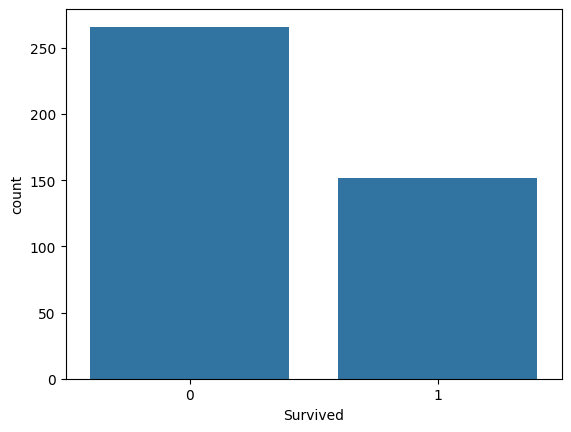

In [89]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.countplot(data=df, x='Survived')
plt.show()


# 1. Resampling Techniques

This method involves adjusting the balance between minority and majority classes through upsampling or downsampling. In the case of an imbalanced dataset, oversampling the minority class with replacement, termed oversampling, is employed. Conversely, undersampling entails randomly removing rows from the majority class to align with the minority class.

This sampling approach yields a balanced dataset, ensuring comparable representation for both majority and minority classes. Achieving a similar number of records for both classes in the dataset signifies that the classifier will assign equal importance to each class during training.

In [90]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


print(f"Original Dataset, counts of label '1': {sum(df['Survived'] == 1)}, counts of label '0': {sum(df['Survived'] == 0)}")

# Over Sampling
oversample = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_oversimple, y_oversimple = oversample.fit_resample(X, y)
print(f"Over Sampled Dataset, counts of label '1': {sum(y_oversimple == 1)}, counts of label '0': {sum(y_oversimple == 0)}")

# Under Sampling
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_undersimple, y_undersimple = undersample.fit_resample(X, y)
print(f"Under Sampled Dataset, counts of label '1': {sum(y_undersimple == 1)}, counts of label '0': {sum(y_undersimple == 0)}")


# Calculate the accuracy after handling the imbalance data
# Over Sampling is more effective than Under Sampling because it does not remove any data
X_train, X_test, y_train, y_test = train_test_split(X_oversimple, y_oversimple, test_size=0.3, random_state=42) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy Model with Over Sampling:",accuracy_score(y_test, y_pred))


Original Dataset, counts of label '1': 152, counts of label '0': 266
Over Sampled Dataset, counts of label '1': 266, counts of label '0': 266
Under Sampled Dataset, counts of label '1': 152, counts of label '0': 152
Accuracy Model with Over Sampling: 0.79375


we can see that the accuracy is increased after handling the imbalance data

# **2. BalancedBaggingClassifier**

When dealing with imbalanced datasets, traditional classifiers tend to favor the majority class, neglecting the minority class due to its lower representation. The BalancedBaggingClassifier, an extension of sklearn classifiers, addresses this imbalance by incorporating additional balancing during training. It introduces parameters like “sampling_strategy,” determining the type of resampling (e.g., ‘majority’ for resampling only the majority class, ‘all’ for resampling all classes), and “replacement,” dictating whether the sampling should occur with or without replacement. This classifier ensures a more equitable treatment of classes, particularly beneficial when handling imbalanced datasets.

In [91]:
from imblearn.ensemble import BalancedBaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# create a random forest Classifier 
clf = RandomForestClassifier(random_state=42)

#create the balanced bagging classifier 
bbc = BalancedBaggingClassifier(clf, 
                                sampling_strategy='auto', # you can change to 'not majority' or 'majority'
                                replacement=False, # this mean that the sample will not be replaced
                                random_state=42)

# fit the model 
bbc.fit(X_train,y_train)
y_pred = bbc.predict(X_test)
print("Accuracy after using the balaced bagging classifier is ",accuracy_score(y_test,y_pred))


Accuracy after using the balaced bagging classifier is  0.6587301587301587


# **3.SMOTE**

The Synthetic Minority Oversampling Technique (SMOTE) addresses imbalanced datasets by synthetically generating new instances for the minority class. Unlike simply duplicating records, SMOTE enhances diversity by creating artificial instances. In simpler terms, SMOTE examines instances in the minority class, selects a random nearest neighbor using k-nearest neighbors, and generates a synthetic instance randomly within the feature space.

In [92]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Class distribution before SMOTE: ",Counter(y_train))

#apply the smote to ever sample the minority class
smote = SMOTE(sampling_strategy='not minority',        
            random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE: ",Counter(y_train_resampled))

# make the prediction

clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)
print("Accuracy after using the SMOTE is ",accuracy_score(y_test,y_pred))

Class distribution before SMOTE:  Counter({0: 181, 1: 111})
Class distribution after SMOTE:  Counter({0: 181, 1: 111})
Accuracy after using the SMOTE is  0.6507936507936508


# **4. Using Tree Based Models**

The hierarchical structure of tree-based models—such as Decision Trees, Random Forests, and Gradient Boosted Trees—allows them to handle imbalanced datasets better than non-tree-based models.

- Decision Trees: Decision trees create a structure resembling a tree by dividing the feature space into regions according to feature values. By changing the decision boundaries to incorporate minority class patterns, decision trees can react to data that is unbalanced. They might experience overfitting, though.
- Random Forests: Random Forests are made up of many Decision Trees that have been trained using arbitrary subsets of features and data. Random Forests improve generalization by reducing overfitting and strengthening robustness against imbalanced datasets by mixing numerous trees.
- Gradient Boosted Trees: Boosted Gradient Trees grow in a sequential fashion, with each new growth repairing the mistakes of the older one. Gradient Boosted Trees perform well in imbalanced circumstances because of their ability to concentrate on misclassifie

# Conclusion

Handling imbalanced data is a crucial step in the data preprocessing pipeline, especially when working on classification problems where one class significantly outnumbers the others. If left unaddressed, imbalanced data can lead to models that are biased towards the majority class, resulting in poor performance on the minority class, which is often of greater interest.